In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

In [2]:
class GenerativeNeuralSDE(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(GenerativeNeuralSDE, self).__init__()
        self.dim = dim
        self.f = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.Linear(hidden_dim, dim)
        )
        self.g = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.Linear(hidden_dim, dim)
        )

    def drift(self, z, t):
        return torch.sigmoid(self.f(z))

    def diffusion(self, z, t):
        return self.g(z)


In [3]:
class InferenceNeuralSDE(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(InferenceNeuralSDE, self).__init__()
        self.dim = dim
        self.f = nn.Sequential(
            nn.Linear(dim + dim, hidden_dim),
            nn.Linear(hidden_dim, dim)
        )
        self.g = nn.Sequential(
            nn.Linear(dim + dim, hidden_dim),
            nn.Linear(hidden_dim, dim)
        )

    def drift(self, z, y, t):
        input = torch.cat([z, y], dim=-1)
        return torch.sigmoid(self.f(input))

    def diffusion(self, z, y, t):
        input = torch.cat([z, y], dim=-1)
        return self.g(input)

In [4]:
def simulate_sde(model, z0, y, t):

    dt = (t[1] - t[0]).item()
    zs = [z0]
    z = z0
    for step in range(len(t)-1):
        current_t = t[step]
        if isinstance(model, InferenceNeuralSDE):
            y_t = y[:, step, :]
            drift = model.drift(z, y_t, current_t)
            diffusion = model.diffusion(z, y_t, current_t)
        else:
            drift = model.drift(z, current_t)
            diffusion = model.diffusion(z, current_t)
        # Euler-Maruyama update
        dw = torch.sqrt(torch.tensor(dt)) * torch.randn_like(z)
        dz = drift * dt + diffusion * dw
        z = z + dz
        zs.append(z)
    return torch.stack(zs, dim=1)  # Shape: [batch_size, len(t), dim]

In [5]:
class ObservationModel(nn.Module):
    def __init__(self, dim_latent, dim_observed):
        super(ObservationModel, self).__init__()
        self.dim_latent = dim_latent
        self.dim_observed = dim_observed
        self.h = nn.Sequential(
            nn.Linear(dim_latent, dim_observed),
            nn.ReLU(),
            nn.Linear(dim_observed, dim_observed)
        )
        # Assume fixed observation noise for simplicity
        self.log_std = nn.Parameter(torch.zeros(dim_observed))

    def forward(self, z):
        return self.h(z)

    def sample_observation(self, z):
        mean = self.forward(z)
        std = torch.exp(self.log_std)
        epsilon = torch.randn_like(mean)
        return mean + std * epsilon

In [6]:
def compute_elbo(generative_model, inference_model, observation_model, y, t, kl_weight=1.0):

    batch_size, seq_len, dim_observed = y.size()
    device = y.device

    z0_prior = torch.randn(batch_size, generative_model.dim).to(device)

    zs_prior = simulate_sde(generative_model, z0_prior, y=None, t=t)

    # Simulate posterior latent trajectories using inference model
    z0_post = torch.randn(batch_size, inference_model.dim).to(device)
    zs_post = simulate_sde(inference_model, z0_post, y, t)

    # Compute reconstruction loss
    y_pred = observation_model.forward(zs_post)
    recon_loss = ((y - y_pred) ** 2).mean()

    # Compute KL divergence between posterior and prior
    # For simplicity, assume both are Gaussians with diagonal covariances
    kl_loss = 0
    for z_prior, z_post in zip(zs_prior.transpose(0,1), zs_post.transpose(0,1)):
        kl_loss += torch.sum(z_post ** 2, dim=-1).mean()
    kl_loss = kl_loss / seq_len

    elbo = recon_loss + kl_weight * kl_loss
    return elbo, recon_loss, kl_loss

In [7]:
def generate_synthetic_data(true_generative_model, observation_model, z0, t):

    with torch.no_grad():
        zs = simulate_sde(true_generative_model, z0, y=None, t=t)
        y = observation_model.sample_observation(zs)  # Add observation noise
    return y

In [8]:
def train_model(generative_model, inference_model, observation_model, optimizer, y, t, epochs=1000, kl_weight=1.0, log_interval=100):

    elbo_history = []
    recon_history = []
    kl_history = []
    for epoch in range(1, epochs + 1):
        generative_model.train()
        inference_model.train()
        observation_model.train()

        optimizer.zero_grad()
        elbo, recon_loss, kl_loss = compute_elbo(generative_model, inference_model, observation_model, y, t, kl_weight)
        elbo.backward()
        optimizer.step()

        elbo_history.append(elbo.item())
        recon_history.append(recon_loss.item())
        kl_history.append(kl_loss.item())

        if epoch % log_interval == 0 or epoch == 1:
            print(f"Epoch {epoch}: ELBO = {elbo.item():.4f}, Recon Loss = {recon_loss.item():.4f}, KL Loss = {kl_loss.item():.4f}")

    return elbo_history, recon_history, kl_history

In [9]:
def run_experiment(sample_size, mesh_size, device, epochs=1000, kl_weight=1.0):

    dim = 2
    dim_observed = 2
    hidden_dim = 16
    t = torch.linspace(0., 10., mesh_size).to(device)

    # Initialize models
    generative_model = GenerativeNeuralSDE(dim, hidden_dim).to(device)
    inference_model = InferenceNeuralSDE(dim, hidden_dim).to(device)
    observation_model = ObservationModel(dim, dim_observed).to(device)

    # Initialize the true generative model
    true_generative_model = GenerativeNeuralSDE(dim, hidden_dim).to(device)
    true_generative_model.load_state_dict(generative_model.state_dict())
    true_generative_model.eval()

    # Generate synthetic data
    z0 = torch.randn(sample_size, dim).to(device)
    y = generate_synthetic_data(true_generative_model, observation_model, z0, t)

    optimizer = optim.Adam(list(generative_model.parameters()) + list(inference_model.parameters()) + list(observation_model.parameters()), lr=1e-3)

    start_time = time.time()
    elbo_history, recon_history, kl_history = train_model(generative_model, inference_model, observation_model, optimizer, y, t, epochs, kl_weight)
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

    # Generate reconstructed data from the inference model
    with torch.no_grad():
        z0_post = torch.randn(sample_size, dim).to(device)
        zs_post = simulate_sde(inference_model, z0_post, y, t)
        y_pred = observation_model.forward(zs_post)

    return y, y_pred, elbo_history, recon_history, kl_history


In [10]:
def plot_results(y, y_pred, elbo_history, recon_history, kl_history, title_suffix=''):

    plt.figure(figsize=(18, 6))

    plt.plot(np.log(elbo_history), 'k-', label='ELBO')
    plt.title(f'Log ELBO over Epochs {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Log ELBO')
    plt.legend()

    plt.tight_layout()
    plt.show()




Starting Experiment: Sample Size = 1000, Mesh Size = 32
Epoch 1: ELBO = 25.1388, Recon Loss = 1.0087, KL Loss = 24.1302
Epoch 100: ELBO = 6.8459, Recon Loss = 1.0080, KL Loss = 5.8379
Epoch 200: ELBO = 4.3249, Recon Loss = 1.0080, KL Loss = 3.3170
Epoch 300: ELBO = 3.4853, Recon Loss = 1.0079, KL Loss = 2.4774
Epoch 400: ELBO = 3.1390, Recon Loss = 1.0081, KL Loss = 2.1309
Epoch 500: ELBO = 3.0108, Recon Loss = 1.0080, KL Loss = 2.0027
Epoch 600: ELBO = 2.6320, Recon Loss = 1.0080, KL Loss = 1.6240
Epoch 700: ELBO = 2.6978, Recon Loss = 1.0082, KL Loss = 1.6896
Epoch 800: ELBO = 2.5614, Recon Loss = 1.0082, KL Loss = 1.5532
Epoch 900: ELBO = 2.4877, Recon Loss = 1.0081, KL Loss = 1.4796
Epoch 1000: ELBO = 2.3984, Recon Loss = 1.0082, KL Loss = 1.3902
Training completed in 51.52 seconds.


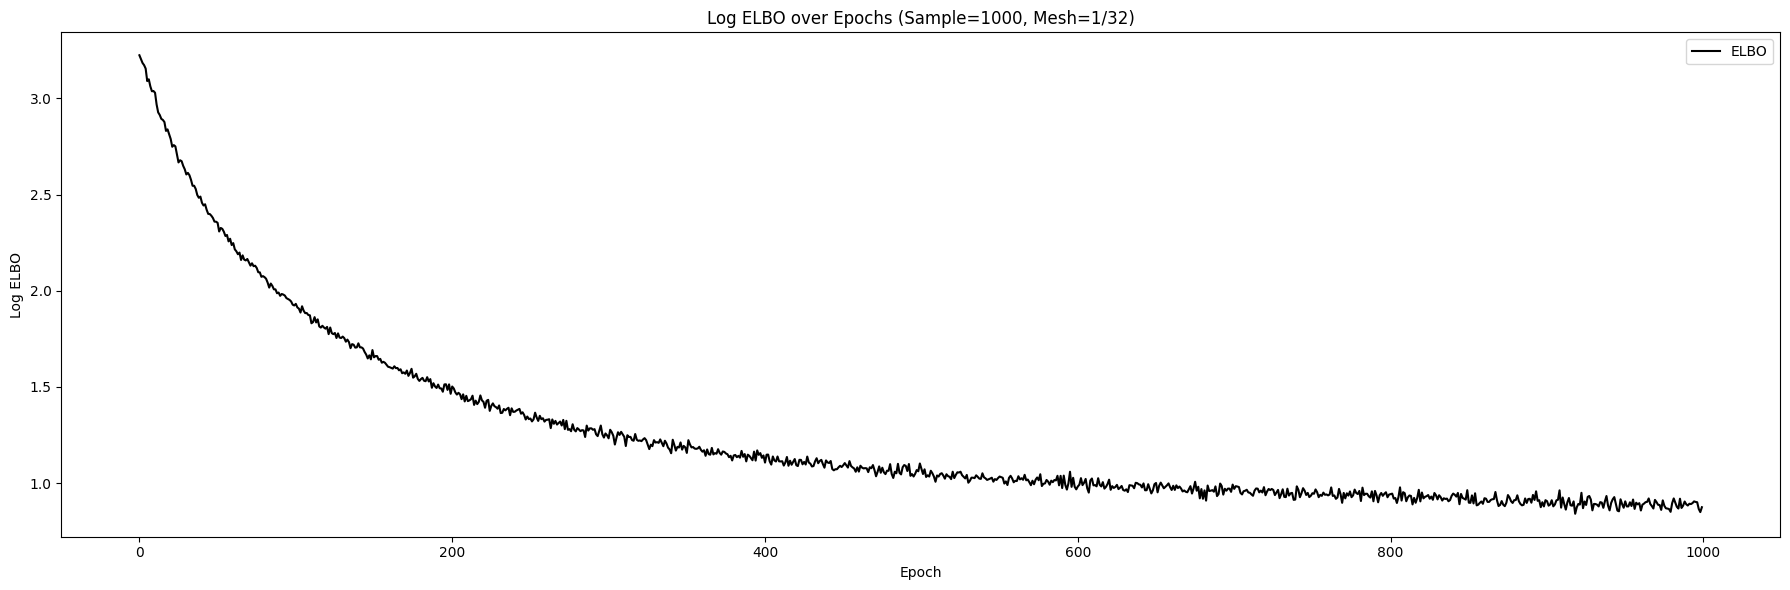

Starting Experiment: Sample Size = 1000, Mesh Size = 64
Epoch 1: ELBO = 14.9044, Recon Loss = 1.3705, KL Loss = 13.5339
Epoch 100: ELBO = 5.2804, Recon Loss = 1.3740, KL Loss = 3.9064
Epoch 200: ELBO = 3.8319, Recon Loss = 1.4198, KL Loss = 2.4121
Epoch 300: ELBO = 3.3975, Recon Loss = 1.4366, KL Loss = 1.9610
Epoch 400: ELBO = 3.0846, Recon Loss = 1.4302, KL Loss = 1.6544
Epoch 500: ELBO = 2.9725, Recon Loss = 1.4139, KL Loss = 1.5586
Epoch 600: ELBO = 2.7943, Recon Loss = 1.4143, KL Loss = 1.3800
Epoch 700: ELBO = 2.7853, Recon Loss = 1.4098, KL Loss = 1.3755
Epoch 800: ELBO = 2.6734, Recon Loss = 1.4082, KL Loss = 1.2652
Epoch 900: ELBO = 2.7747, Recon Loss = 1.4006, KL Loss = 1.3741
Epoch 1000: ELBO = 2.6223, Recon Loss = 1.3994, KL Loss = 1.2228
Training completed in 83.53 seconds.


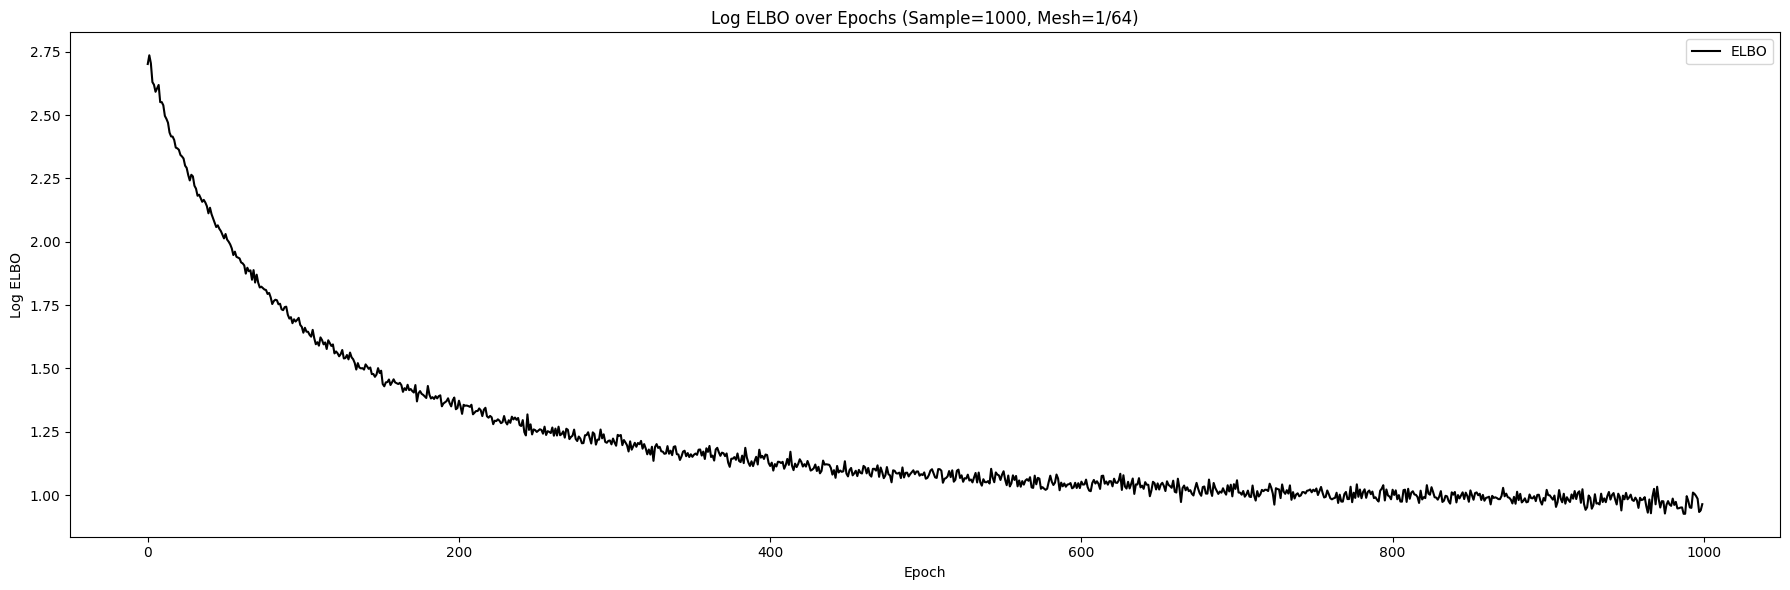

Starting Experiment: Sample Size = 1000, Mesh Size = 128
Epoch 1: ELBO = 18.6754, Recon Loss = 1.1675, KL Loss = 17.5079
Epoch 100: ELBO = 7.1594, Recon Loss = 1.1355, KL Loss = 6.0239
Epoch 200: ELBO = 4.5652, Recon Loss = 1.1325, KL Loss = 3.4327
Epoch 300: ELBO = 3.7069, Recon Loss = 1.1317, KL Loss = 2.5752
Epoch 400: ELBO = 3.2256, Recon Loss = 1.1319, KL Loss = 2.0937
Epoch 500: ELBO = 2.8977, Recon Loss = 1.1314, KL Loss = 1.7663
Epoch 600: ELBO = 2.6752, Recon Loss = 1.1311, KL Loss = 1.5441
Epoch 700: ELBO = 2.5853, Recon Loss = 1.1314, KL Loss = 1.4539
Epoch 800: ELBO = 2.5173, Recon Loss = 1.1320, KL Loss = 1.3853
Epoch 900: ELBO = 2.4259, Recon Loss = 1.1311, KL Loss = 1.2948
Epoch 1000: ELBO = 2.5171, Recon Loss = 1.1317, KL Loss = 1.3854
Training completed in 164.00 seconds.


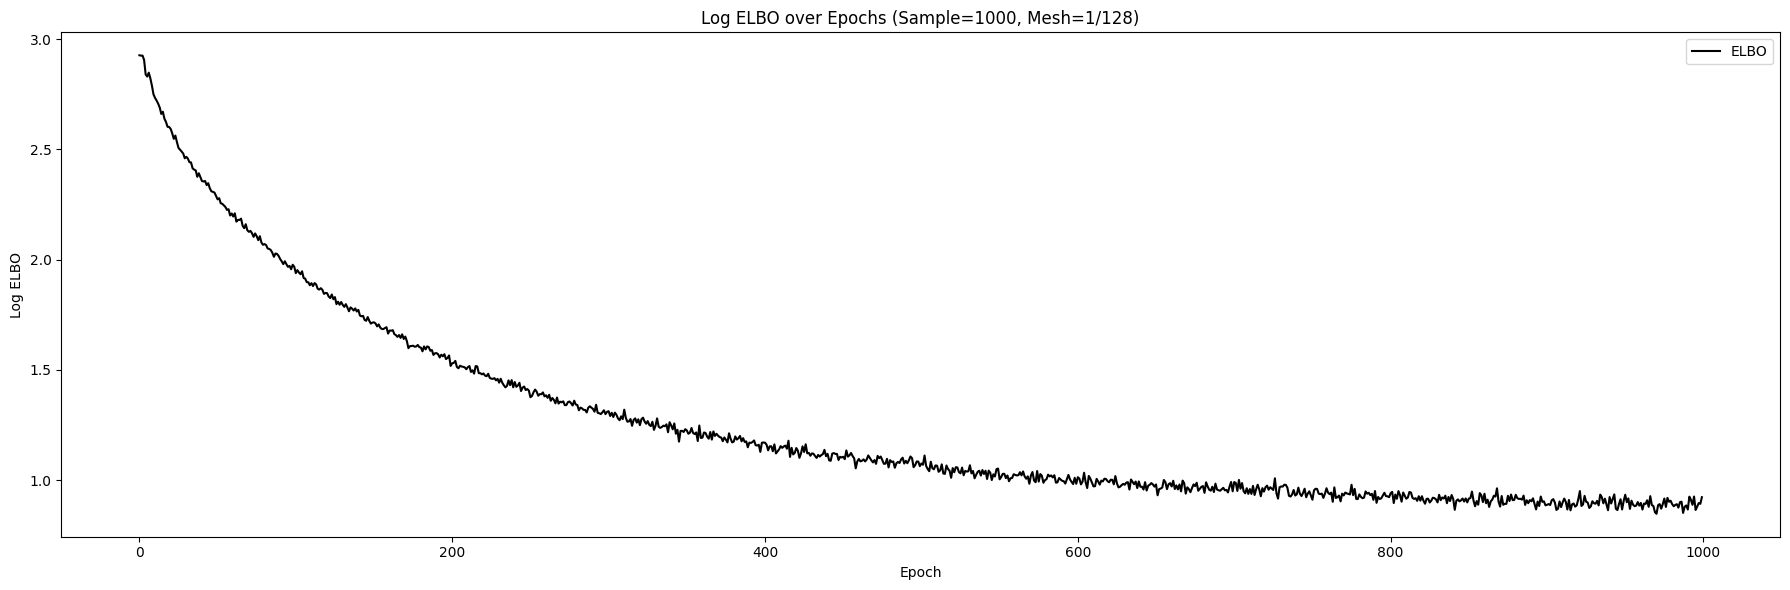

Starting Experiment: Sample Size = 1000, Mesh Size = 256
Epoch 1: ELBO = 14.8361, Recon Loss = 1.2550, KL Loss = 13.5811
Epoch 100: ELBO = 5.8379, Recon Loss = 1.1574, KL Loss = 4.6805
Epoch 200: ELBO = 3.9888, Recon Loss = 1.1485, KL Loss = 2.8403
Epoch 300: ELBO = 3.3260, Recon Loss = 1.1421, KL Loss = 2.1839
Epoch 400: ELBO = 2.8297, Recon Loss = 1.1401, KL Loss = 1.6895
Epoch 500: ELBO = 2.6785, Recon Loss = 1.1410, KL Loss = 1.5375
Epoch 600: ELBO = 2.5194, Recon Loss = 1.1368, KL Loss = 1.3827
Epoch 700: ELBO = 2.5946, Recon Loss = 1.1386, KL Loss = 1.4560
Epoch 800: ELBO = 2.4495, Recon Loss = 1.1380, KL Loss = 1.3116
Epoch 900: ELBO = 2.4510, Recon Loss = 1.1380, KL Loss = 1.3130
Epoch 1000: ELBO = 2.3139, Recon Loss = 1.1380, KL Loss = 1.1759
Training completed in 336.48 seconds.


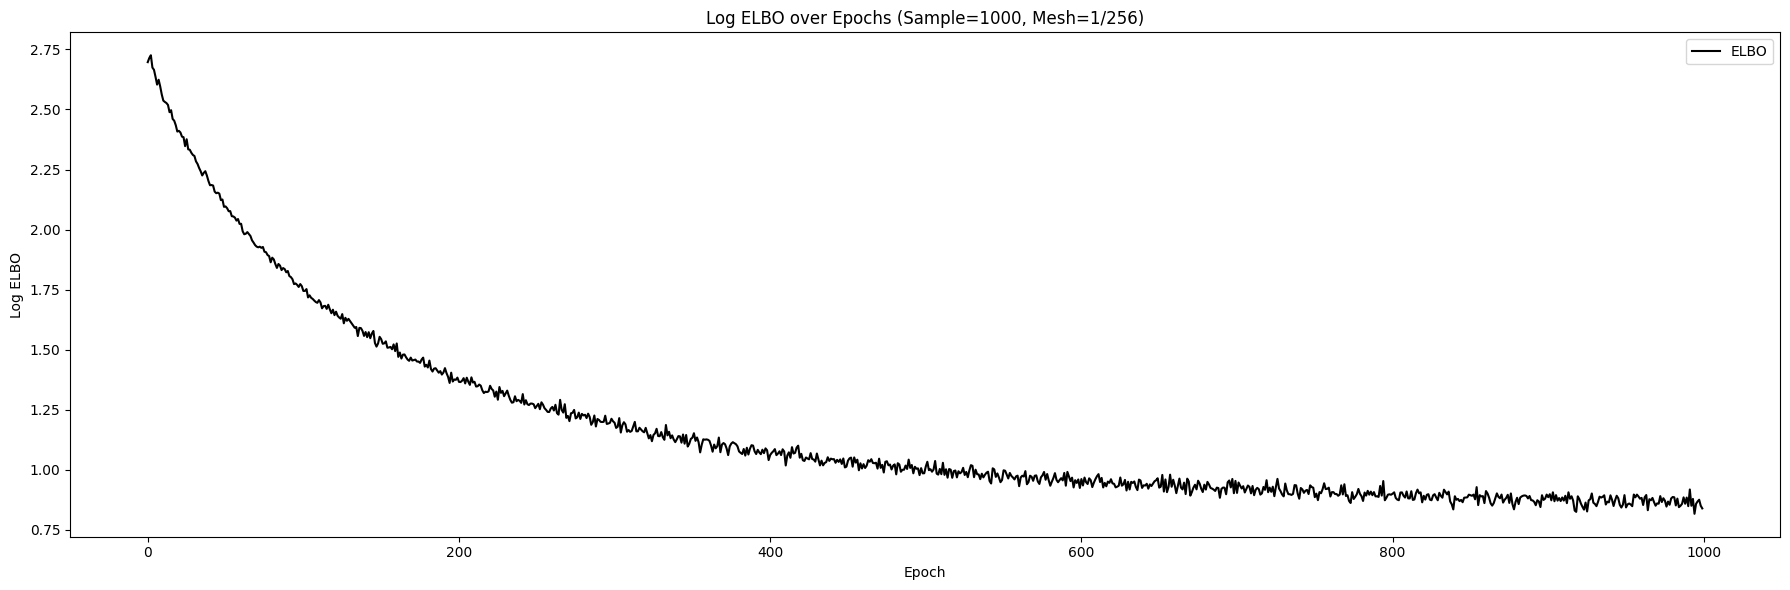

Starting Experiment: Sample Size = 1000, Mesh Size = 512
Epoch 1: ELBO = 33.7065, Recon Loss = 2.6718, KL Loss = 31.0347
Epoch 100: ELBO = 9.5169, Recon Loss = 2.3741, KL Loss = 7.1428
Epoch 200: ELBO = 6.0814, Recon Loss = 2.3538, KL Loss = 3.7276
Epoch 300: ELBO = 5.0037, Recon Loss = 2.3516, KL Loss = 2.6521
Epoch 400: ELBO = 4.6232, Recon Loss = 2.3533, KL Loss = 2.2700
Epoch 500: ELBO = 4.3308, Recon Loss = 2.3458, KL Loss = 1.9851
Epoch 600: ELBO = 4.0443, Recon Loss = 2.3529, KL Loss = 1.6914
Epoch 700: ELBO = 4.1184, Recon Loss = 2.3486, KL Loss = 1.7697
Epoch 800: ELBO = 3.9337, Recon Loss = 2.3478, KL Loss = 1.5859
Epoch 900: ELBO = 3.8979, Recon Loss = 2.3489, KL Loss = 1.5490
Epoch 1000: ELBO = 3.7217, Recon Loss = 2.3461, KL Loss = 1.3757
Training completed in 671.64 seconds.


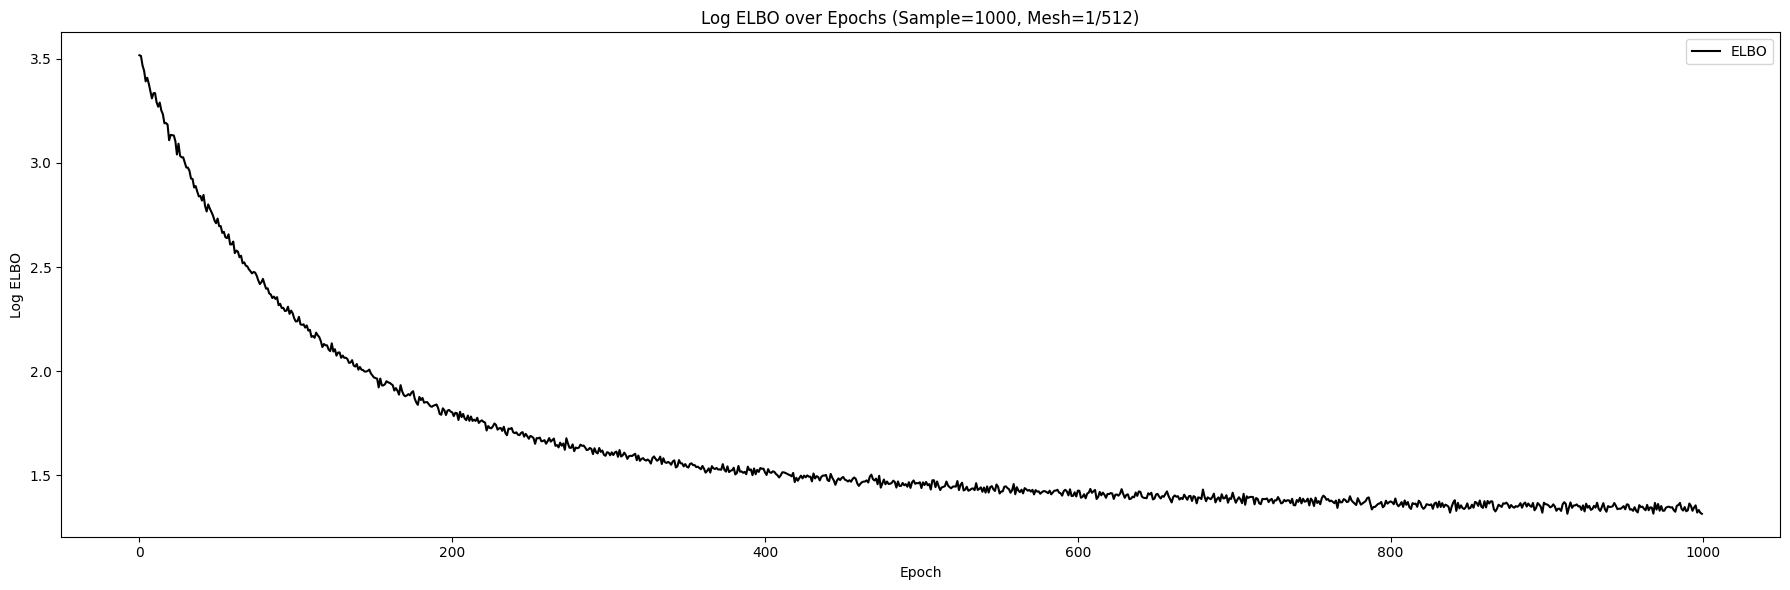

Starting Experiment: Sample Size = 50, Mesh Size = 32
Epoch 1: ELBO = 29.0595, Recon Loss = 1.1781, KL Loss = 27.8813
Epoch 100: ELBO = 9.1228, Recon Loss = 1.0896, KL Loss = 8.0332
Epoch 200: ELBO = 6.4257, Recon Loss = 1.1014, KL Loss = 5.3244
Epoch 300: ELBO = 4.1668, Recon Loss = 1.0943, KL Loss = 3.0725
Epoch 400: ELBO = 4.0158, Recon Loss = 1.0894, KL Loss = 2.9264
Epoch 500: ELBO = 3.3083, Recon Loss = 1.0907, KL Loss = 2.2176
Epoch 600: ELBO = 3.4340, Recon Loss = 1.1012, KL Loss = 2.3328
Epoch 700: ELBO = 2.7093, Recon Loss = 1.0965, KL Loss = 1.6129
Epoch 800: ELBO = 2.6473, Recon Loss = 1.0942, KL Loss = 1.5531
Epoch 900: ELBO = 2.6375, Recon Loss = 1.0957, KL Loss = 1.5418
Epoch 1000: ELBO = 2.7495, Recon Loss = 1.1021, KL Loss = 1.6474
Training completed in 41.40 seconds.


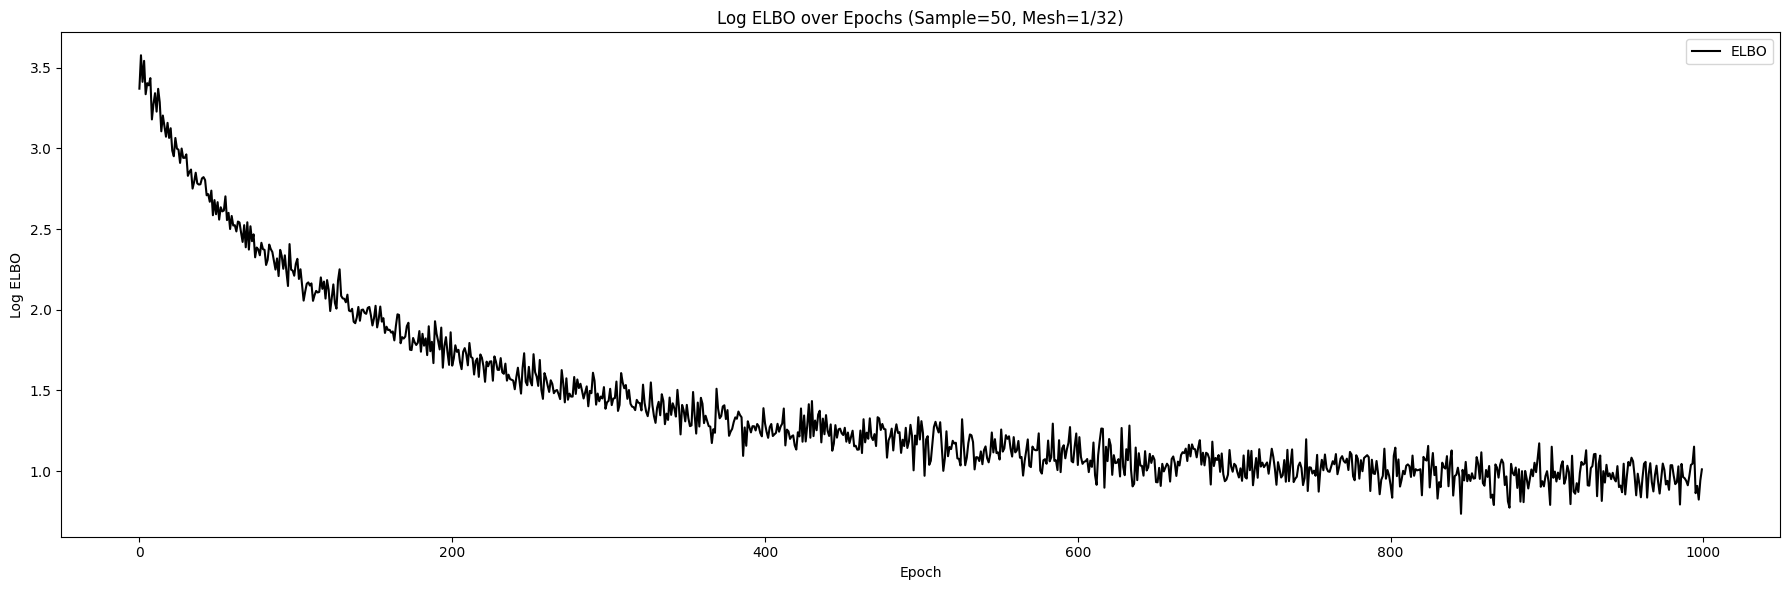

Starting Experiment: Sample Size = 100, Mesh Size = 32
Epoch 1: ELBO = 23.3740, Recon Loss = 1.1058, KL Loss = 22.2682
Epoch 100: ELBO = 7.0645, Recon Loss = 1.0874, KL Loss = 5.9771
Epoch 200: ELBO = 4.7985, Recon Loss = 1.0909, KL Loss = 3.7075
Epoch 300: ELBO = 3.7273, Recon Loss = 1.0846, KL Loss = 2.6427
Epoch 400: ELBO = 3.3658, Recon Loss = 1.0927, KL Loss = 2.2731
Epoch 500: ELBO = 3.0994, Recon Loss = 1.0912, KL Loss = 2.0082
Epoch 600: ELBO = 2.6040, Recon Loss = 1.0935, KL Loss = 1.5105
Epoch 700: ELBO = 2.5166, Recon Loss = 1.0916, KL Loss = 1.4250
Epoch 800: ELBO = 2.3955, Recon Loss = 1.0917, KL Loss = 1.3038
Epoch 900: ELBO = 2.9313, Recon Loss = 1.0913, KL Loss = 1.8400
Epoch 1000: ELBO = 2.4294, Recon Loss = 1.0923, KL Loss = 1.3370
Training completed in 40.72 seconds.


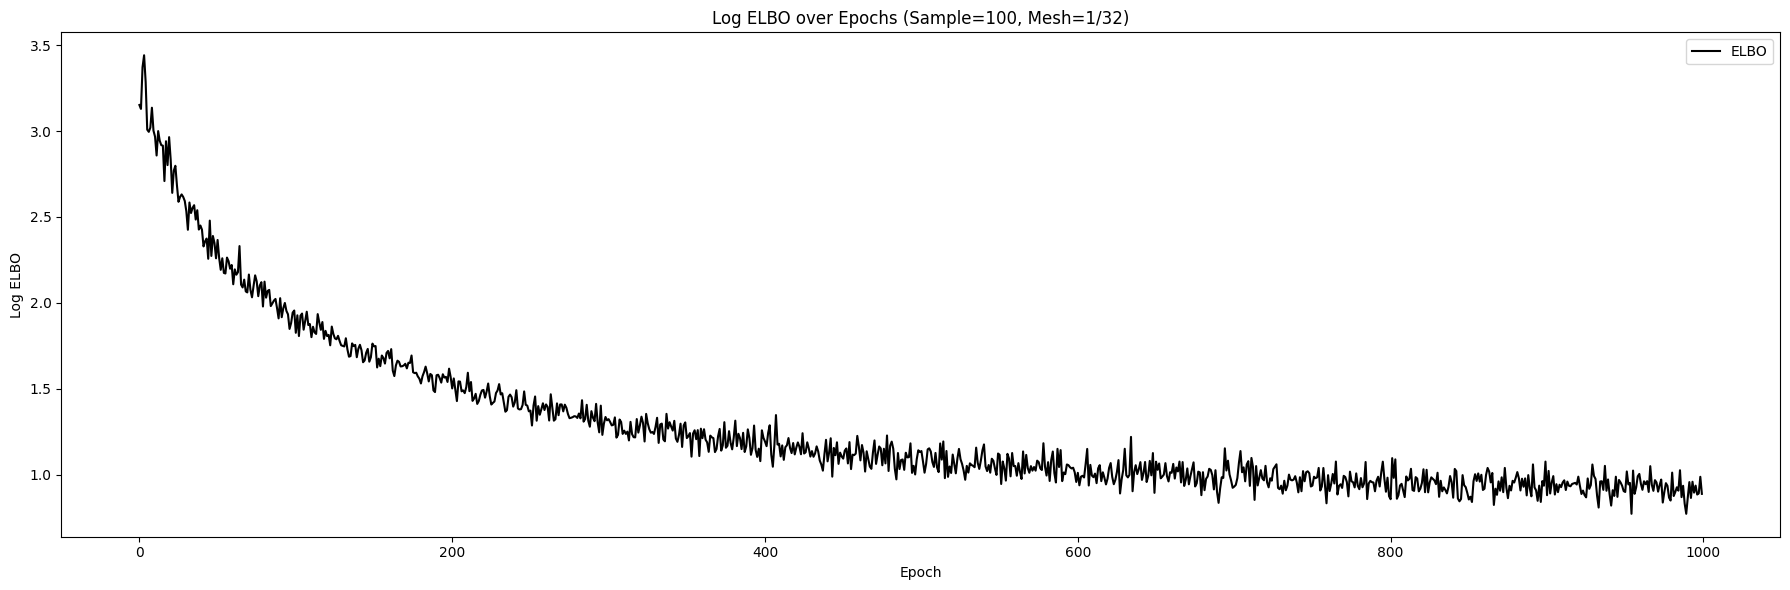

Starting Experiment: Sample Size = 1000, Mesh Size = 32
Epoch 1: ELBO = 20.4122, Recon Loss = 2.3049, KL Loss = 18.1072
Epoch 100: ELBO = 7.2150, Recon Loss = 2.0241, KL Loss = 5.1909
Epoch 200: ELBO = 4.9438, Recon Loss = 1.8597, KL Loss = 3.0841
Epoch 300: ELBO = 4.1695, Recon Loss = 1.8130, KL Loss = 2.3565
Epoch 400: ELBO = 3.5996, Recon Loss = 1.7245, KL Loss = 1.8750
Epoch 500: ELBO = 3.3570, Recon Loss = 1.6795, KL Loss = 1.6775
Epoch 600: ELBO = 3.2605, Recon Loss = 1.6824, KL Loss = 1.5781
Epoch 700: ELBO = 3.0422, Recon Loss = 1.6613, KL Loss = 1.3809
Epoch 800: ELBO = 3.1587, Recon Loss = 1.6844, KL Loss = 1.4743
Epoch 900: ELBO = 3.0612, Recon Loss = 1.6665, KL Loss = 1.3947
Epoch 1000: ELBO = 3.0816, Recon Loss = 1.6851, KL Loss = 1.3965
Training completed in 41.96 seconds.


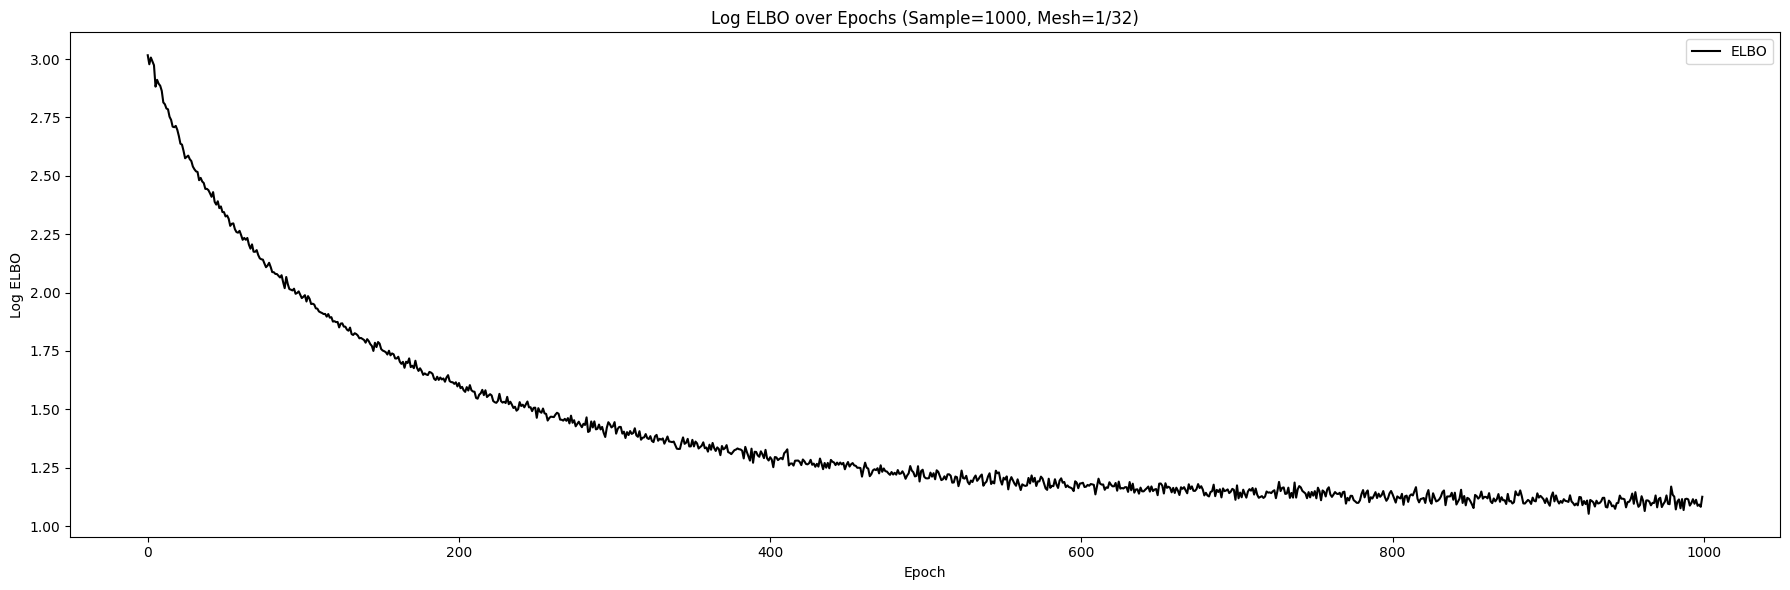

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define experimental settings
experiments = [
    {'sample_size': 1000, 'mesh_size': 32, 'title_suffix': '(Sample=1000, Mesh=1/32)'},
    {'sample_size': 1000, 'mesh_size': 64, 'title_suffix': '(Sample=1000, Mesh=1/64)'},
    {'sample_size': 1000, 'mesh_size': 128, 'title_suffix': '(Sample=1000, Mesh=1/128)'},
    {'sample_size': 1000, 'mesh_size': 256, 'title_suffix': '(Sample=1000, Mesh=1/256)'},
    {'sample_size': 1000, 'mesh_size': 512, 'title_suffix': '(Sample=1000, Mesh=1/512)'},
    {'sample_size': 50, 'mesh_size': 32, 'title_suffix': '(Sample=50, Mesh=1/32)'},
    {'sample_size': 100, 'mesh_size': 32, 'title_suffix': '(Sample=100, Mesh=1/32)'},
    {'sample_size': 1000, 'mesh_size': 32, 'title_suffix': '(Sample=1000, Mesh=1/32)'},
]

for exp in experiments:
    print(f"Starting Experiment: Sample Size = {exp['sample_size']}, Mesh Size = {exp['mesh_size']}")
    y, y_pred, elbo_history, recon_history, kl_history = run_experiment(
        sample_size=exp['sample_size'],
        mesh_size=exp['mesh_size'],
        device=device,
        epochs=1000,
        kl_weight=1.0
    )
    plot_results(y, y_pred, elbo_history, recon_history, kl_history, title_suffix=exp['title_suffix'])